In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.8 kB/s 
     |████████████████████████████████| 8.8 MB 33.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.2.0+cu92 which is incompatible.


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
import pandas as pd 
import numpy as np
df = pd.read_pickle('gdrive/My Drive/image_224x224_sale.pkl')
X = df['image_pixel']
y = df['high_sale']
X = X.to_numpy()
X = np.stack(X, axis=0)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
X = np.transpose(X, (0, 3, 1, 2))

In [ ]:
from sklearn.model_selection import train_test_split
# Split into 0.75:0.125:0.125
X = X/255.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.14286, random_state=42)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of dev examples = " + str(X_dev.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_dev shape: " + str(X_dev.shape))
print ("Y_dev shape: " + str(y_dev.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1179
number of dev examples = 197
number of test examples = 197
X_train shape: (1179, 3, 224, 224)
Y_train shape: (1179,)
X_dev shape: (197, 3, 224, 224)
Y_dev shape: (197,)
X_test shape: (197, 3, 224, 224)
Y_test shape: (197,)


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

In [ ]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from torch.utils.data import Dataset
 
class ImageDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
 
  def __len__(self):
    return len(self.X)
 
  def __getitem__(self, idx):
    return X[idx], y[idx]

In [ ]:
# download and prepare the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainloader = torch.utils.data.DataLoader(ImageDataset(X_train, y_train), batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(ImageDataset(X_dev, y_dev), batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


TypeError: ignored

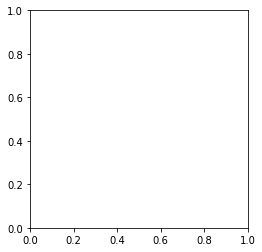

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [ ]:
# downloading the vgg16 network
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from collections import OrderedDict
# change the number of output classes from 1000 to 10
layers_vgg16 = nn.Sequential(OrderedDict([
  ('fc1', nn.Linear(25088, 512)),
  ('activation1', nn.ReLU()),
  ('dropout1', nn.Dropout()),
  ('fc2', nn.Linear(512, 256)),
  ('activation2', nn.ReLU()),
  ('dropout2', nn.Dropout()),
  ('fc3', nn.Linear(256, 128)),
  ('activation3', nn.ReLU()),
  ('dropout3', nn.Dropout()),
  ('fc4', nn.Linear(128, 1)),
  ('out', nn.Sigmoid())])).to(device)

vgg16.classifier = layers_vgg16
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def validation(model, val_loader, criterion, device):
    '''
    Helper validation loss and accuracy function for use during model training
    Args:
        model: model object (ex: vgg16, resnet or custom model using nn.Module)
        val_loader: data loader for validation set
        criterion: loss function used for training
        device: cuda or cpu device
    Returns:
        test_loss: the loss during validation testing
        accuracy: the accuracy during validation testing
    '''

    test_loss = 0
    total = 0
    correct = 0
    for i, data in enumerate(val_loader):
        X, y = data[0].to(device, dtype=torch.float), data[1].float().unsqueeze(1).to(device)
        output = model(X)
        test_loss += criterion(output, y).item()

        for index, i in enumerate(output):
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1

    accuracy = correct/total

    return test_loss, accuracy

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, device, scheduler = None):
    '''
    Training loop function
    Args:
        model: model: model object (ex: vgg16, resnet or custom model using nn.Module)
        train_loader: data loader object with the training data
        val_loader: data loader object with the validation images
        optimizer: optimier used from torchvision.optim
        criterion: loss function used
        epochs: number of epochs that training loop runs
        device: cuda or cpu device
        scheduler: (optional) learning rate scheduler
    Returns:
        plot_train_loss: numpy array of training loss every epoch (length of epochs)
        plot_val_loss: numpy array of validation loss every epoch (length of epochs)
        plot_train_acc: numpy array of training accuracy every epoch (length of epochs)
        plot_val_acc: numpy array of validation accuracy every epoch (length of epochs)
    '''

    plot_train_loss = []
    plot_val_loss = []
    plot_train_acc = []
    plot_val_acc = []
    for epoch in range(epochs):
        model.train()
        total = 0
        correct = 0
        train_loss = 0
        for i, data in enumerate(train_loader):
            X, y = data[0].to(device, dtype=torch.float), data[1].float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

            for index, i in enumerate(output):
                if torch.argmax(i) == y[index]:
                    correct+=1
                total+=1

        if scheduler is not None:
            scheduler.step()
        
        model.eval()

        with torch.no_grad():
            val_loss, val_acc = validation(model, val_loader, criterion, device = device)

        train_acc = correct/total

        print("Training Loss:", train_loss)
        plot_train_loss.append(train_loss)

        print("Training Accuracy:", train_acc)
        plot_train_acc.append(train_acc)

        print("Validation Loss:", val_loss)
        plot_val_loss.append(val_loss)

        print("Validation Accuracy:", val_acc)
        plot_val_acc.append(val_acc)

        model.train()

    plot_train_loss = np.array(plot_train_loss) 
    plot_val_loss = np.array(plot_val_loss)
    plot_train_acc = np.array(plot_train_acc)
    plot_val_acc = np.array(plot_val_acc)

    return plot_train_loss, plot_val_loss, plot_train_acc, plot_val_acc

In [ ]:
# optimizer
optimizer = optim.Adam(vgg16.classifier.parameters())
# loss function
criterion = nn.BCELoss()
# epochs
epochs = 5

In [ ]:
plot_train_loss, plot_val_loss, plot_train_acc, plot_val_acc = train(vgg16, trainloader, testloader, optimizer, criterion, epochs, device)

Training Loss: 25.04744166135788
Training Accuracy: 0.4071246819338422
Validation Loss: 4.798031866550446
Validation Accuracy: 0.41116751269035534
Training Loss: 25.062870681285858
Training Accuracy: 0.4071246819338422
Validation Loss: 4.737677037715912
Validation Accuracy: 0.41116751269035534
Training Loss: 25.065567076206207
Training Accuracy: 0.4071246819338422
Validation Loss: 4.795336842536926
Validation Accuracy: 0.41116751269035534
Training Loss: 25.06546014547348
Training Accuracy: 0.4071246819338422
Validation Loss: 4.798960268497467
Validation Accuracy: 0.41116751269035534
Training Loss: 25.084867477416992
Training Accuracy: 0.4071246819338422
Validation Loss: 4.68023294210434
Validation Accuracy: 0.41116751269035534
